# The Price is Right: Airbnb Pricing Recommendation

In [37]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
import warnings

In [44]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', 200)

HTML('''
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

.output {
    display: flex;
    align-items: left;
    text-align: justify;
}

</style>


<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

In [20]:
df = pd.read_csv('dataset/finaldataversion11.csv')

## Executive Summary

Last year, as with most other businesses, Airbnb was rocked by COVID-19. Multiple news about Airbnb's future headlined several articles as large numbers of cancellations and slow bookings created a massive loss in revenue globally but even more appalling is the situation of its hosts.

With the current situation, the collapse of startups has been prevalent during the pandemic. **Airbnb experienced a booking drop over 70% and cut its half in valuation.**

In the wake of the pandemic, emergence of **dynamic pricing** has become a business strategy for survival. With that our project aims to provide a data-driven pricing strategy by:

1. Identifying the factors affecting the price of listings
2. Train a Machine Learning Model that identifies a pricing system for PH Airbnb hosts to optimize their listing price

## Data Information

Our data contains available Airbnb listings together with their details ranging from price to various property types along with proximity analysis which is the calculated distance of an Airbnb listing to a spatial feature such as if the listing is nearby an airport, supermarkets and listings.

Data was acquired on March 26, 2021. **This model is a prototype for this specific timestamp** in order to take into account the price variability with respect to time. 

The following information was scraped from each listing:

1. Title

2. Location (province, latitude, and longitude)

3. Capacity Information (e.g. Number of guest, number of bedrooms)

4. Property Type (e.g. Entire apartment)

5. Price

6. Amenities

7. Description badges (e.g. Enhanced Clean)

8. Reviews (number only)

9. Ratings


### Spatial Distribution of Listings

A total of **11,409** listings in the Philippines were used in the analysis and regression. **Most of the listings are distributed along the coastline.**
The provinces with no Airbnb listings are **Tawi-tawi, Sulu and Basilan.**


<img src="images/datainfo.png" width="500">

### Distribution of Price per Night

Airbnb prices range from **30 PHP to 48,160 PHP** with an average of **2,327 PHP** per night. The most expensive property is an **entire villa** while the cheapest is a **shared room.**

In [31]:
print('Descriptive Statistics')
df['price_per_night'].describe()

Descriptive Statistics


count    11409.00000
mean      2327.06153
std       3033.00194
min         30.00000
25%       1000.00000
50%       1500.00000
75%       2450.00000
max      48160.00000
Name: price_per_night, dtype: float64

In [45]:
print('Listings with the least and most expensive price per night')
df[(df['price_per_night'] == df['price_per_night'].min()) | (df['price_per_night'] == df['price_per_night'].max())]

Listings with the least and most expensive price per night


,url,rating,type_airbnb,guests,number_of_beds,number_of_bedrooms,number_of_bathrooms,price_per_night,latitude,longitude,rating_cleanliness,rating_accuracy,rating_communication,rating_location,rating_checkin,rating_value,population,area,travelers_2019,foreign_travelers,covid_total,covid_active,superhost,host_identity_verified,sound_system,child_friendly,fireplace,hygiene_kit,washing_machine,beddings,fire_safety_equipment,clothes_storage,kettle,waterfront,compactor,security_cameras,sauna,parking,game_console,gym,balcony,piano,swimming_pool,indoor_games,wifi,hair_dryer,bathtub,hot_water,iron,safe,keypad,kitchen,tv,refrigerator,streaming_service,airconditioning,oven,grill,utensils,bidet,breakfast,staff,fan,heating,dedicated_workspace,dining_table,cooking_basics,elevator,garden,first_aid_kit,entire_home,enhanced_clean,cancellation_policy,experienced_host,free_parking_on_premises,great_checkin_experience,great_communication,great_location,highly_rated_host,house_rules,laptop_friendly_workspace,outstanding_hospitality,pets_allowed,self_checkin,sparkling_clean,is_shared_room,is_private_room,num_nearby_listings,num_nearby_tourist_spots_3km,num_nearby_tourist_spots_5km,num_nearby_malls_5km,num_nearby_supermarkets_3km,num_nearby_supermarkets_5km,num_nearby_restaurants_3km,num_nearby_restaurants_5km,num_nearby_public_transpo_5km,distance_airport_kms,province,Abra,Agusan del Norte,Agusan del Sur,Aklan,Albay,Antique,Apayao,Aurora,Bataan,Batanes,Batangas,Benguet,Biliran,Bohol,Bukidnon,Bulacan,Cagayan,Caloocan City,Camarines Norte,Camarines Sur,Camiguin,Capiz,Catanduanes,Cavite,Cebu,Compostela Valley,Cotabato,Davao Occidental,Davao Oriental,Davao del Norte,Davao del Sur,Dinagat Islands,Eastern Samar,Guimaras,Ifugao,Ilocos Norte,Ilocos Sur,Iloilo,Isabela,Kalinga,La Union,Laguna,Lanao del Norte,Lanao del Sur,Las Piñas City,Leyte,Maguindanao,Makati City,Malabon City,Mandaluyong City,Manila City,Marikina City,Marinduque,Masbate,Misamis Occidental,Misamis Oriental,Mountain Province,Muntinlupa City,Navotas City,Negros Occidental,Negros Oriental,Northern Samar,Nueva Ecija,Nueva Vizcaya,Occidental Mindoro,Oriental Mindoro,Palawan,Pampanga,Pangasinan,Parañaque City,Pasay City,Pasig City,Pateros,Quezon,Quezon City,Quirino,Rizal,Romblon,Samar,San Juan City,Sarangani,Siquijor,Sorsogon,South Cotabato,Southern Leyte,Sultan Kudarat,Surigao del Norte,Surigao del Sur,Taguig City,Tarlac,Valenzuela City,Zambales,Zamboanga Sibugay,Zamboanga del Norte,Zamboanga del Sur,num_reviews,within_3km_from_highway,within_750m_from_coast,type_airbnb_label,province_label,private_room,private_room_in_cave,shared_room,houseboat,campsite,earth_house,entire_place,entire_resort,entire_villa,farm_stay,island
797,https://www.airbnb.com/rooms/41343254?previous...,NaN,shared room in house,8,4,1,4.0,30,11.02815,125.73002,NaN,NaN,NaN,NaN,NaN,NaN,467160,4660,76976,912,1265,27,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,79.978843,Eastern Samar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,33,0,0,1,0,0,0,0,0,0,0,0
8134,https://www.airbnb.com/rooms/44920938?previous...,NaN,private room in bed and breakfast,16,9,6,8.0,48160,15.17165,120.03430,NaN,NaN,NaN,NaN,NaN,NaN,823888,3830,850240,76644,2462,100,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,0,0,0,1,1,1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,56.513736,Zambales,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,92,1,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Frequency')

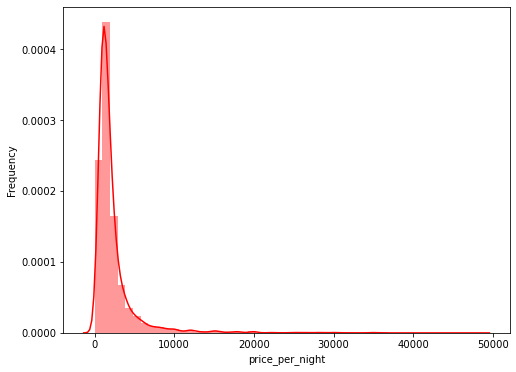

In [46]:
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(df['price_per_night'], color='red', ax=ax)
plt.ylabel('Frequency')

In [ ]:
Fu

In [47]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['#ff5a5f', '#00a698'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price_per_night.median().plot(kind='bar', ax=ax2, color=['#ff5a5f', '#00a698'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (PHP)')
    ax2.set_xlabel('')
    
    plt.show()